In [1]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from tqdm import tqdm

np.random.seed(0)

params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
prop_cycle = plt.rcParams['axes.prop_cycle']

In [2]:
def F(u):
    return (u**2 - 1)**2/4

def f(u):
    return u - u**3

## Plot Double Well Potential

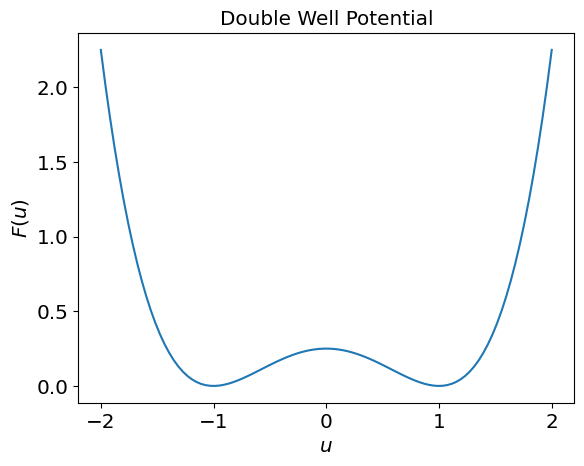

In [3]:
u = np.linspace(-2, 2, 100)
plt.plot(u, F(u))
plt.xlabel("$u$")
plt.ylabel("$F(u)$")
plt.title("Double Well Potential")
plt.savefig("double-well-potential.pdf", bbox_inches="tight")
plt.show()

## Allen-Cahn Equation

### Initial Condition

Here we choose $u_0(x; \mu) = \mu_1x(x-1)(x-\mu_2)$ with $\mu_1, \mu_2 \in [0.1, 0.9]$.

In [4]:
def u0(x, mu):
    return mu[0]*x*(x-1)*(x-mu[1])

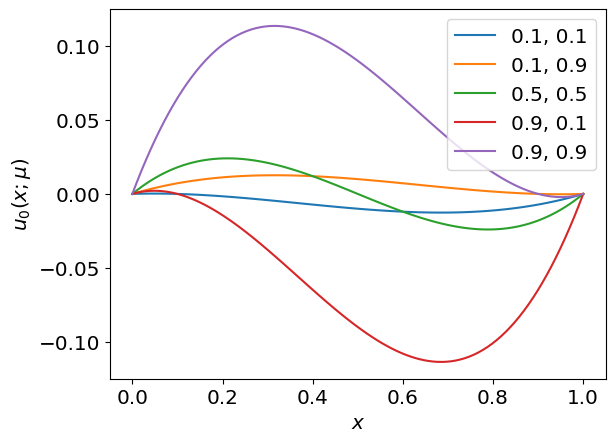

In [5]:
# plot some examples of u0
x = np.linspace(0, 1, 100)
plt.plot(x, u0(x, [0.1, 0.1]), label="0.1, 0.1")
plt.plot(x, u0(x, [0.1, 0.9]), label="0.1, 0.9")
plt.plot(x, u0(x, [0.5, 0.5]), label="0.5, 0.5")
plt.plot(x, u0(x, [0.9, 0.1]), label="0.9, 0.1")
plt.plot(x, u0(x, [0.9, 0.9]), label="0.9, 0.9")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$u_0(x; \\mu)$")
plt.show()

### Solve the Equation

In [6]:
def solve_allen_cahn_forward_euler(Nt, Nx, mu):
    # discretize space and time
    x = np.linspace(0, 1, Nx)
    t = np.linspace(0, 1, Nt)

    dt = t[1] - t[0] # time step
    dx = x[1] - x[0] # space step
    A = (np.diag(-2*np.ones(Nx)) + np.diag(np.ones(Nx-1), 1) + np.diag(np.ones(Nx-1), -1))/dx**2

    # initialize solution
    sol = np.zeros((Nt, Nx))
    sol[0] = u0(x, mu) # set time 0 to be initial condition

    # time step with forward Euler
    for t_i in range(1, Nt):
        sol[t_i] = sol[t_i-1] + dt*A@sol[t_i-1] + dt*f(sol[t_i-1])
    
    return sol

In [7]:
def solve_allen_cahn_convex_splitting(Nt, Nx, mu):
    # discretize space and time
    x = np.linspace(0, 1, Nx)
    t = np.linspace(0, 1, Nt)

    dt = t[1] - t[0] # time step
    dx = x[1] - x[0] # space step
    A = (np.diag(-2*np.ones(Nx)) + np.diag(np.ones(Nx-1), 1) + np.diag(np.ones(Nx-1), -1))/dx**2

    # initialize solution
    sol = np.zeros((Nt, Nx))
    sol[0] = u0(x, mu) # set time 0 to be initial condition

    # time step with forward Euler
    for t_i in range(1, Nt):
        # want this function to equal 0
        def func(s):
            return (s - sol[t_i-1])/dt - A @ (s + sol[t_i-1])/2 + (s**3 - sol[t_i-1])
        root = fsolve(func, sol[t_i-1])
        sol[t_i] = root
    
    return sol

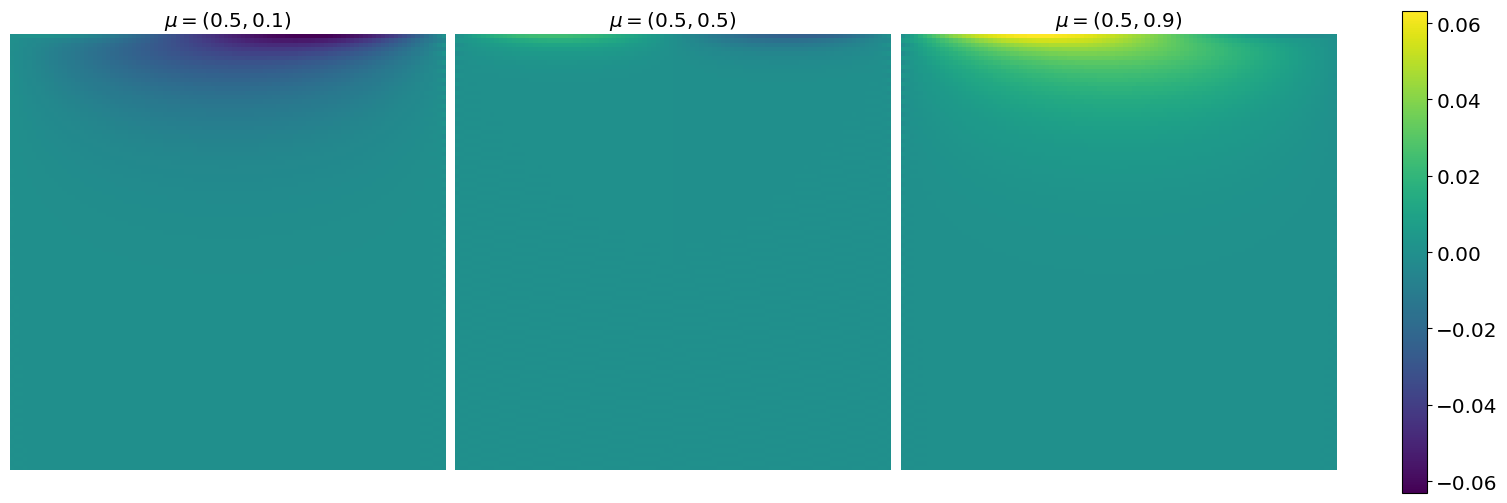

In [8]:
Nt = 100
Nx = 100

# solve Allen-Cahn for three different parameters
mu = np.array([0.5, 0.1])
sol1 = solve_allen_cahn_convex_splitting(Nt, Nx, mu)

mu = np.array([0.5, 0.5])
sol2 = solve_allen_cahn_convex_splitting(Nt, Nx, mu)

mu = np.array([0.5, 0.9])
sol3 = solve_allen_cahn_convex_splitting(Nt, Nx, mu)

# plot results
fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)
vmin = min(sol1.min(), sol2.min(), sol3.min())
vmax = max(sol1.max(), sol2.max(), sol3.max())

im1 = axes[0].imshow(sol1, vmin=vmin, vmax=vmax, extent=[0, 1, 0, 1])
axes[0].set_title("$\\mu = (0.5, 0.1)$")
axes[0].set_axis_off()

im2 = axes[1].imshow(sol2, vmin=vmin, vmax=vmax, extent=[0, 1, 0, 1])
axes[1].set_title("$\\mu = (0.5, 0.5)$")
axes[1].set_axis_off()

im3 = axes[2].imshow(sol3, vmin=vmin, vmax=vmax, extent=[0, 1, 0, 1])
axes[2].set_title("$\\mu = (0.5, 0.9)$")
axes[2].set_axis_off()

fig.colorbar(im1, ax=axes, orientation='vertical', fraction=.1)
plt.savefig("allen-cahn-solutions.pdf", bbox_inches="tight")
plt.show()

## Singular Values of Snapshot Matrix: Fast Decay!

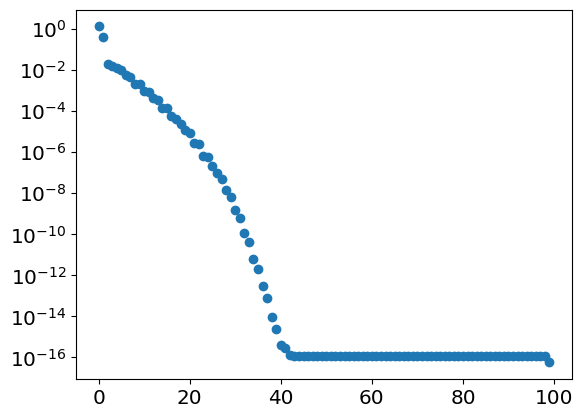

In [9]:
snapshots = np.concatenate((sol1, sol2, sol3)).T
U, S, V = np.linalg.svd(snapshots, full_matrices=False)
plt.scatter(np.arange(S.shape[0]), S)
plt.yscale('log')
plt.show()

## Building a ROM

From this plot of the singular values, we see that we can take a small rank $r$, say $r=30$, to capture the data in our snapshot matrix. Let's now make a ROM to solve the Allen-Cahn equation.

In [10]:
r = 25
U_r = U[:, :r]

Nt = 100
Nx = 100

# discretize space and time
x = np.linspace(0, 1, Nx)
t = np.linspace(0, 1, Nt)

dt = t[1] - t[0] # time step
dx = x[1] - x[0] # space step
A = (U_r.T @ (np.diag(-2*np.ones(Nx)) + np.diag(np.ones(Nx-1), 1) + np.diag(np.ones(Nx-1), -1)) @ U_r)/dx**2

def solve_allen_cahn_rom(Nt, Nx, mu):
    # initialize solution
    sol = np.zeros((Nt, r))
    sol[0] = U_r.T @ u0(x, mu) # set time 0 to be initial condition

    # time step with forward Euler
    for t_i in range(1, Nt):
        # want this function to equal 0
        def func(s):
            return (s - sol[t_i-1])/dt - A @ (s + sol[t_i-1])/2 + U_r.T @ ((U_r@s)**3 - U_r@sol[t_i-1])
        root = fsolve(func, sol[t_i-1])
        sol[t_i] = root
    
    return sol

In [11]:
snapshots_rom = None
for mu1, mu2 in [(0.5, 0.1), (0.5, 0.5), (0.5, 0.9)]:
    sol = solve_allen_cahn_rom(Nt, Nx, np.array([mu1, mu2]))
    if snapshots_rom is None:
        snapshots_rom = sol
    else:
        snapshots_rom = np.concatenate((snapshots_rom, sol))
snapshots_rom = snapshots_rom.T

In [12]:
print("Error on POD sample points")
print("Relative Error:", np.linalg.norm(snapshots - U_r @ snapshots_rom) / np.linalg.norm(snapshots), 
      "Absolute Error:", np.linalg.norm(snapshots - U_r @ snapshots_rom))

Error on POD sample points
Relative Error: 2.1129567203345927e-07 Absolute Error: 2.8734133304986594e-07


## Compute Error on New Samples

In [13]:
rom_solutions = []
hf_solutions = []

for trial in tqdm(range(15)):
    mu1 = np.random.uniform(0.1, 0.9)
    mu2 = np.random.uniform(0.1, 0.9)
    sol_rom = solve_allen_cahn_rom(Nt, Nx, np.array([mu1, mu2]))
    sol_hf = solve_allen_cahn_convex_splitting(Nt, Nx, np.array([mu1, mu2]))

    rom_solutions.append(sol_rom)
    hf_solutions.append(sol_hf)

100%|█████████████████████████████████████████████████████████████████████████████| 15/15 [04:26<00:00, 17.79s/it]


In [14]:
error_ = np.sqrt(np.sum((np.array(rom_solutions)@U_r.T - np.array(hf_solutions))**2))
norm_ = np.sqrt(np.sum(np.array(hf_solutions)**2))

print("Error on randomly sampled points")
print("Relative Error:", error_/norm_, "Absolute Error:", error_)

Error on randomly sampled points
Relative Error: 3.0020973953270936e-07 Absolute Error: 6.671133805482317e-07


## DEIM

In [17]:
# Compute SVD of nonlinear snapshots
G1 = sol1[:-1] - (sol1**3)[1:]
G2 = sol2[:-1] - (sol2**3)[1:]
G3 = sol3[:-1] - (sol3**3)[1:]
G = np.concatenate((G1, G2, G3)).T
U_, S_, V_ = np.linalg.svd(G, full_matrices=False)
V_r = U_[:, :r]

# Apply the column pivoting algorithm to the orthonormal basis
V_r_copy = np.copy(V_r)
I = []
for k in range(r):
    i = np.argmax(V_r_copy[:, k])
    I.append(i)
    V_r_copy = V_r_copy - 1/V_r_copy[i, k] * V_r_copy[:, [k]] @ V_r_copy[[i], :]
S = np.zeros((V_r.shape[0], r))
for i in range(r):
    S[I[i], i] = 1
I = np.array(I)

# define DEIM approximation
Nt = 100
Nx = 100

# discretize space and time
x = np.linspace(0, 1, Nx)
t = np.linspace(0, 1, Nt)

dt = t[1] - t[0] # time step
dx = x[1] - x[0] # space step
A = (U_r.T @ (np.diag(-2*np.ones(Nx)) + np.diag(np.ones(Nx-1), 1) + np.diag(np.ones(Nx-1), -1)) @ U_r)/dx**2
B = U_r.T @ V_r @ np.linalg.inv(S.T @ V_r)

def solve_allen_cahn_deim(Nt, Nx, mu):
    # initialize solution
    sol = np.zeros((Nt, r))
    sol[0] = U_r.T @ u0(x, mu) # set time 0 to be initial condition

    # time step with forward Euler
    for t_i in range(1, Nt):
        # want this function to equal 0
        def func(s):
            return (s - sol[t_i-1])/dt - A @ (s + sol[t_i-1])/2 + B @ ((U_r[I]@s)**3 - U_r[I]@sol[t_i-1])
        root = fsolve(func, sol[t_i-1])
        sol[t_i] = root
    
    return sol

In [18]:
rom_solutions = []
deim_solutions = []

for trial in tqdm(range(15)):
    mu1 = np.random.uniform(0.1, 0.9)
    mu2 = np.random.uniform(0.1, 0.9)
    sol_rom = solve_allen_cahn_rom(Nt, Nx, np.array([mu1, mu2]))
    sol_deim = solve_allen_cahn_deim(Nt, Nx, np.array([mu1, mu2]))

    rom_solutions.append(sol_rom)
    deim_solutions.append(sol_deim)

100%|█████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 11.98it/s]


In [19]:
error_ = np.sqrt(np.sum((np.array(rom_solutions)@U_r.T - np.array(deim_solutions)@U_r.T)**2))
norm_ = np.sqrt(np.sum((np.array(rom_solutions)@U_r.T)**2))

print("Error on randomly sampled points")
print("Relative Error:", error_/norm_, "Absolute Error:", error_)

Error on randomly sampled points
Relative Error: 3.344246131120839e-08 Absolute Error: 7.670966528900746e-08
